In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('../input.csv')

In [3]:
df['label'].value_counts()

label
ntj    32929
ytj    12710
Name: count, dtype: int64

In [4]:
duplicated_all = df[df.duplicated(subset='link_id', keep=False)]
duplicated = df[df.duplicated(subset='link_id', keep='first')]

if not duplicated.empty:
    first_duplicate_id = duplicated['link_id'].iloc[0]
    print(df[df['link_id'] == first_duplicate_id])
else:
    print("No duplicates found excluding the first occurrence.")

No duplicates found excluding the first occurrence.


# NLTK

In [5]:
# Function to map NLTK's part-of-speech tags to wordnet tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN
    
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Set of English stop words
stop_words = set(stopwords.words('english'))

def nltk_lemmatizer(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmas = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) 
        for word, pos in pos_tags 
        if word.isalpha() and word.lower() not in stop_words
    ]
    return lemmas


In [6]:
# Encode target variable
def encode_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le


text_transformer = TfidfVectorizer(tokenizer=nltk_lemmatizer, token_pattern=None)

# Column Transformer
column_transformer = ColumnTransformer([
    ("txt", text_transformer, 'selftext'),
    
], remainder='drop')


# Process data and encode target
X = df.drop(columns=['label'])
y_encoded, label_encoder = encode_target(df['label'])

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Preprocess training data: Apply transformations and resampling
X_train_transformed = column_transformer.fit_transform(X_train)
print(f'Shape of data after TF-IDF: {X_train_transformed.shape}')
# X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train_transformed, y_train)
# print(f'Shape of data after SMOTE: {X_resampled.shape}')

# # Apply dimensionality reduction
# svd_transformer = TruncatedSVD(random_state=42, n_components=1000)
# X_reduced = svd_transformer.fit_transform(X_resampled)
# print(f'Shape of data after TruncatedSVD: {X_reduced.shape}')

# Preprocess validation data
X_val_transformed = column_transformer.transform(X_val)
# X_val_reduced = svd_transformer.transform(X_val_transformed)

Shape of data after TF-IDF: (31947, 39679)


In [7]:
from joblib import dump
# Save the transformers
dump(column_transformer, 'column_transformer.joblib')
# dump(svd_transformer, 'svd_transformer.joblib')
dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

# Baseline Models

# Random Forest

In [8]:
rf_baseline = Pipeline([
#     ('preprocessing', column_transformer),
    ('classifier', RandomForestClassifier())
])

# Fit RF baseline model
rf_baseline.fit(X_train_transformed, y_train)

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [9]:
# Evaluate on the validation set
predictions = rf_baseline.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("Random Forest Accuracy: {:.2f}".format(accuracy))

# Save the rf model
dump(rf_baseline, 'rf_baseline.joblib')

Random Forest Accuracy: 0.72


['rf_baseline.joblib']

## Logistic Regression

In [12]:
lr_baseline = Pipeline([
#     ('preprocessing', column_transformer),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit Logistic Regression baseline model
lr_baseline.fit(X_train_transformed, y_train)

C:\Users\shreenithi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('classifier', LogisticRegression(random_state=42))])

In [13]:
# Evaluate on the validation set
predictions = lr_baseline.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("Logistic Regression Accuracy: {:.2f}".format(accuracy))

# Save the best model
dump(lr_baseline, 'lr_baseline.joblib')

Logistic Regression Accuracy: 0.72


['lr_baseline.joblib']

## Decision Tree

In [14]:
dt_baseline = Pipeline([
#     ('preprocessing', column_transformer),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit Decision Tree baseline model
dt_baseline.fit(X_train_transformed, y_train)

Pipeline(steps=[('classifier', DecisionTreeClassifier(random_state=42))])

In [15]:
# Evaluate on the validation set
predictions = dt_baseline.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("Decision Tree Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(dt_baseline, 'dt_baseline.joblib')

Decision Tree Accuracy with Hyperparameter Tuning: 0.61


['dt_baseline.joblib']

# Support Vector Classifier

In [16]:
svc_baseline = Pipeline([
#     ('preprocessing', column_transformer),
    ('classifier', SVC(random_state=42))
])

# Fit Decision Tree baseline model
svc_baseline.fit(X_train_transformed, y_train)

Pipeline(steps=[('classifier', SVC(random_state=42))])

In [17]:
# Evaluate on the validation set
predictions = svc_baseline.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("Support Vector Classifier Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(svc_baseline, 'svc_baseline.joblib')

Support Vector Classifier Accuracy with Hyperparameter Tuning: 0.72


['svc_baseline.joblib']

## XGBoost

In [18]:
xgb_baseline = Pipeline([
#     ('preprocessing', column_transformer),
    ('classifier', XGBClassifier(random_state=42))
])

# Fit Decision Tree baseline model
xgb_baseline.fit(X_train_transformed, y_train)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [19]:
# Evaluate on the validation set
predictions = xgb_baseline.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("XGBoost Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(xgb_baseline, 'xgb_baseline.joblib')

XGBoost Accuracy with Hyperparameter Tuning: 0.71


['xgb_baseline.joblib']

In [20]:
# Transform the test dataset
X_test_transformed = column_transformer.transform(X_test)


In [21]:
# Apply dimensionality reduction
# svd_transformer = TruncatedSVD(random_state=42, n_components=1000)
# X_test_reduced = svd_transformer.fit_transform(X_test_transformed)

Best parameters for RandomForest:
{'memory': None, 'steps': [('classifier', RandomForestClassifier())], 'verbose': False, 'classifier': RandomForestClassifier(), 'classifier__bootstrap': True, 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 100, 'classifier__n_jobs': None, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__warm_start': False}
Classification Report for RandomForest on Test Dataset:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4940
           1       0.78      0.02      0.03      1906

    accura

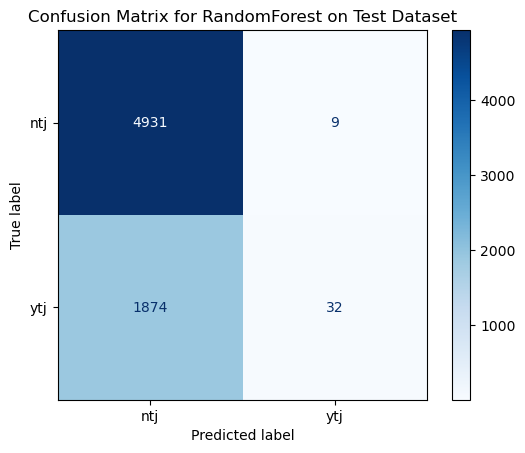

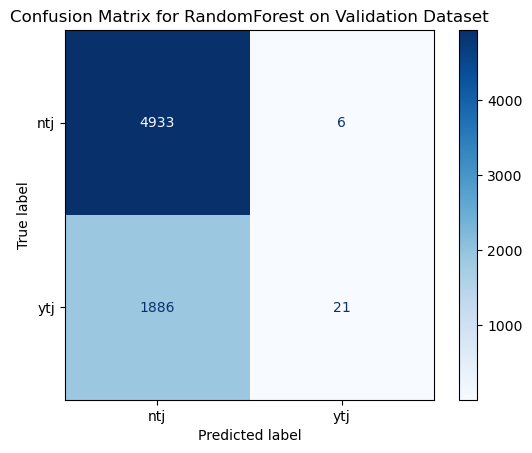



Best parameters for Logistic Regression:
{'memory': None, 'steps': [('classifier', LogisticRegression(random_state=42))], 'verbose': False, 'classifier': LogisticRegression(random_state=42), 'classifier__C': 1.0, 'classifier__class_weight': None, 'classifier__dual': False, 'classifier__fit_intercept': True, 'classifier__intercept_scaling': 1, 'classifier__l1_ratio': None, 'classifier__max_iter': 100, 'classifier__multi_class': 'auto', 'classifier__n_jobs': None, 'classifier__penalty': 'l2', 'classifier__random_state': 42, 'classifier__solver': 'lbfgs', 'classifier__tol': 0.0001, 'classifier__verbose': 0, 'classifier__warm_start': False}
Classification Report for Logistic Regression on Test Dataset:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      4940
           1       0.54      0.12      0.19      1906

    accuracy                           0.73      6846
   macro avg       0.64      0.54      0.51      6846
weighted avg      

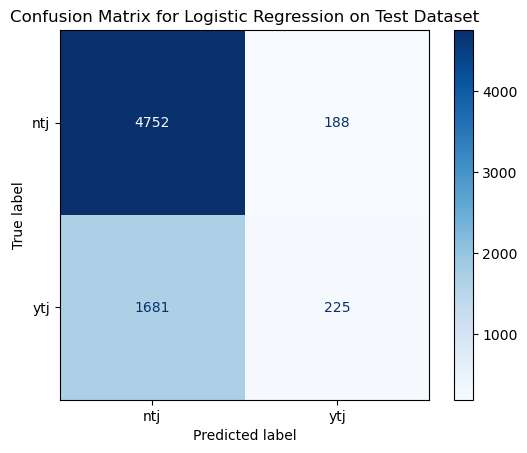

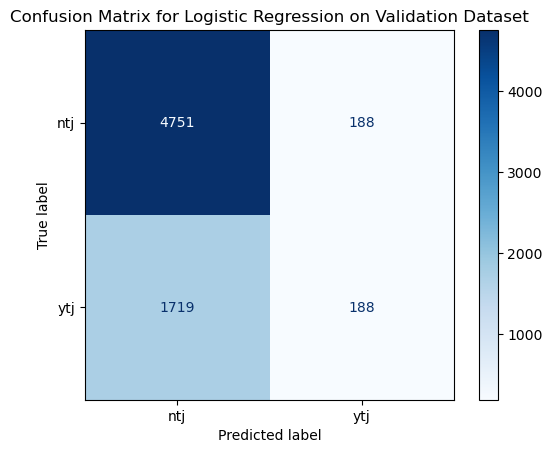



Best parameters for DecisionTree:
{'memory': None, 'steps': [('classifier', DecisionTreeClassifier(random_state=42))], 'verbose': False, 'classifier': DecisionTreeClassifier(random_state=42), 'classifier__ccp_alpha': 0.0, 'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__max_leaf_nodes': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__random_state': 42, 'classifier__splitter': 'best'}
Classification Report for DecisionTree on Test Dataset:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      4940
           1       0.31      0.30      0.30      1906

    accuracy                           0.62      6846
   macro avg       0.52      0.52      0.52      6846
weighted avg       0.61      0.62      0.62      6846

Cla

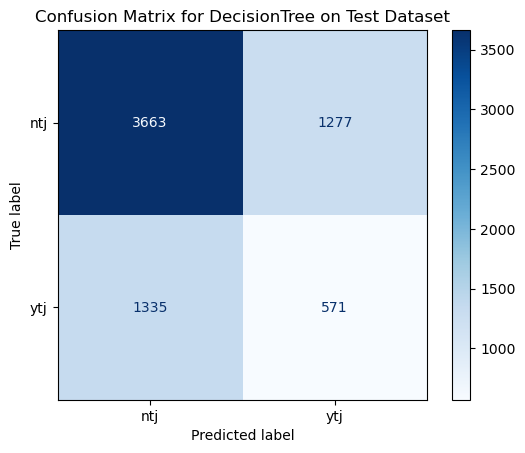

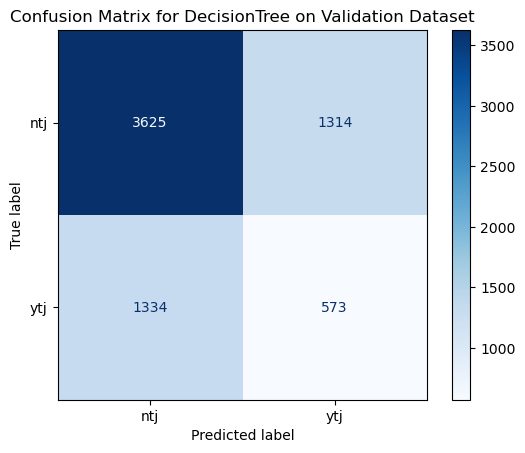



Best parameters for SVC:
{'memory': None, 'steps': [('classifier', SVC(random_state=42))], 'verbose': False, 'classifier': SVC(random_state=42), 'classifier__C': 1.0, 'classifier__break_ties': False, 'classifier__cache_size': 200, 'classifier__class_weight': None, 'classifier__coef0': 0.0, 'classifier__decision_function_shape': 'ovr', 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'classifier__max_iter': -1, 'classifier__probability': False, 'classifier__random_state': 42, 'classifier__shrinking': True, 'classifier__tol': 0.001, 'classifier__verbose': False}
Classification Report for SVC on Test Dataset:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      4940
           1       0.76      0.03      0.06      1906

    accuracy                           0.73      6846
   macro avg       0.75      0.51      0.45      6846
weighted avg       0.74      0.73      0.62      6846

Classification Report 

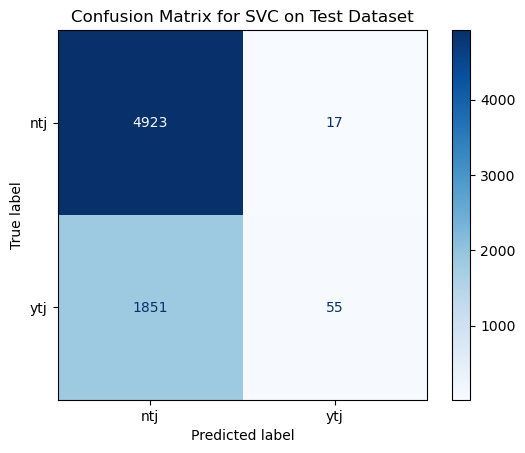

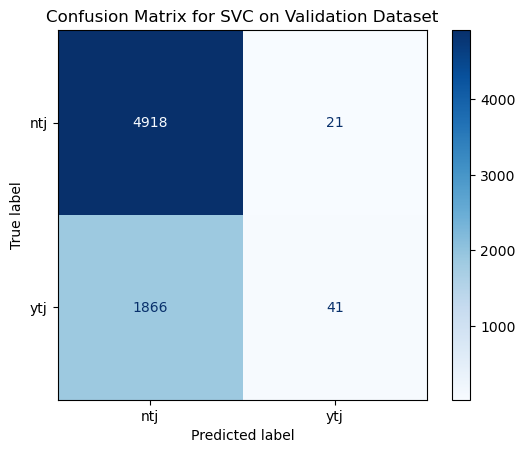



Best parameters for XGBoost:
{'memory': None, 'steps': [('classifier', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...))], 'verbose': False, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              

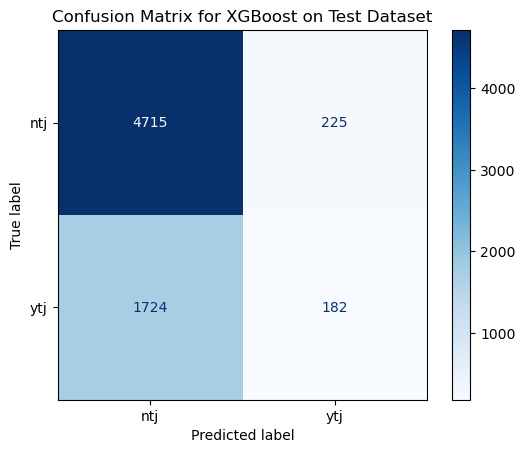

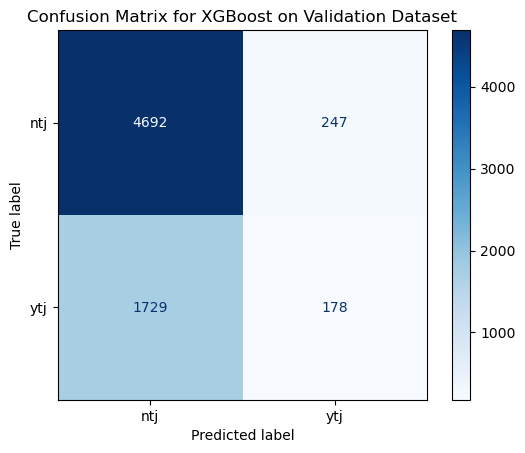

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# List of best models and their names
best_models = {
    "RandomForest": rf_baseline,
    "Logistic Regression": lr_baseline,
    "DecisionTree": dt_baseline,
    "SVC": svc_baseline,
    "XGBoost": xgb_baseline
}
# Generate reports for each model
for model_name, model in best_models.items():
    print(f"Best parameters for {model_name}:")
    print(model.get_params())
    
    # Predict on the test dataset
    y_test_pred = model.predict(X_test_transformed)
    
    # Predict on the validation dataset
    y_val_pred = model.predict(X_val_transformed)
    
    # Generate classification report for the test dataset
    print(f"Classification Report for {model_name} on Test Dataset:")
    print(classification_report(y_test, y_test_pred))
    
    # Generate classification report for the validation dataset
    print(f"Classification Report for {model_name} on Validation Dataset:")
    print(classification_report(y_val, y_val_pred))
    
    # Plot confusion matrix for the test dataset
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
    disp_test.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} on Test Dataset")
    plt.show()
    
    # Plot confusion matrix for the validation dataset
    cm_val = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_encoder.classes_)
    disp_val.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} on Validation Dataset")
    plt.show()
    
    print("\n" + "="*60 + "\n")
